# SimFin Tutorial 10 - Neural Networks

[Original repository on GitHub](https://github.com/simfin/simfin-tutorials)

This tutorial was originally written by [Hvass Labs](https://github.com/Hvass-Labs)

----

"The attackers can be stopped by removing the head or destroying the brain." &ndash; [Shaun of The Dead](https://www.youtube.com/watch?v=ONEZfj6h1xc)

## Introduction

In the previous tutorial we used a Machine Learning (ML) model to try and predict future stock-returns for 1-3 year investment periods given various signals. This worked quite well on the training-set, but unfortunately it failed to generalize to the test-set.

In this tutorial we will use a so-called Neural Network, which has become very fashionable in recent years, because they have been able to solve extremely hard problems, that were previously impossible to solve.

Unfortunately, Neural Networks have become so hyped, that people sometimes misunderstand what they really are: A Neural Network is just a function approximator that maps some input x (e.g. signals) to some output y (e.g. stock-returns). It consists of a number of layers of both linear and non-linear mappings, whose parameters will be learned during the training process, so it learns to map from x to y in the training-set, and the learned mapping hopefully generalizes to new data.

In theory, a Neural Network is capable of approximating any function to any desired degree of precision - but what is truly important, is not how well it performs on the training-set, but how well it performs on new data that it has not seen during the training.

This tutorial shows how to use financial data from SimFin with the TensorFlow library for creating Neural Networks. It is assumed you are already familiar with both.

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

# TensorFlow and Keras imports.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.utils import to_categorical

# Scikit-learn imports.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [2]:
# Version of the SimFin Python API.
sf.__version__

'0.3.0'

In [3]:
# TensorFlow version.
tf.__version__

'2.0.0'

## SimFin Config

In [4]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

In [5]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [6]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

## Data Hub

We use a `StockHub` object to easily load and process financial data with these settings:

In [7]:
# We are interested in the US stock-market.
market = 'us'

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

In [8]:
%%time
hub = sf.StockHub(market=market, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices)

CPU times: user 23 µs, sys: 4 µs, total: 27 µs
Wall time: 33.4 µs


## Signals

First we calculate financial signals for the stocks, such as the Current Ratio, Debt Ratio, Net Profit Margin, Return on Assets, etc. These are calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

In [9]:
%%time
df_fin_signals = hub.fin_signals(variant='daily')

Dataset "us-income-ttm" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (1 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-2a38bb7d.pickle' on disk (1 days old).
- Loading from disk ... Done!
CPU times: user 14.4 s, sys: 1.05 s, total: 15.5 s
Wall time: 15.5 s


Now we calculate growth signals for the stocks, such as Earnings Growth, FCF Growth, Sales Growth, etc. These are also calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

In [10]:
%%time
df_growth_signals = hub.growth_signals(variant='daily')

Dataset "us-income-quarterly" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (1 days old).
- Loading from disk ... Done!
Cache-file 'growth_signals-2a38bb7d.pickle' on disk (1 days old).
- Loading from disk ... Done!
CPU times: user 817 ms, sys: 296 ms, total: 1.11 s
Wall time: 1.11 s


Now we calculate valuation signals for the stocks, such as P/E, P/Sales, etc. These are calculated from the share-prices and data from the financial reports. Because the data-hub has already loaded the required datasets in the function-calls above, the data is merely reused here, and the data-hub can proceed directly to computing the signals.

In [11]:
%%time
df_val_signals = hub.val_signals(variant='daily')

Cache-file 'val_signals-739b68a6.pickle' on disk (1 days old).
- Loading from disk ... Done!
CPU times: user 137 ms, sys: 276 ms, total: 413 ms
Wall time: 413 ms


We now combine all the signals into a single DataFrame:

In [12]:
%%time
# Combine the DataFrames.
dfs = [df_fin_signals, df_growth_signals, df_val_signals]
df_signals = pd.concat(dfs, axis=1)

CPU times: user 1.39 s, sys: 219 ms, total: 1.61 s
Wall time: 1.61 s


We can then show the results:

In [13]:
df_signals.dropna(how='all').head()

Asset Turnover  Current Ratio  Debt Ratio  \
Ticker Date                                                    
A      2011-06-29             NaN       3.201005     0.24789   
       2011-06-30             NaN       3.201005     0.24789   
       2011-07-01             NaN       3.201005     0.24789   
       2011-07-05             NaN       3.201005     0.24789   
       2011-07-06             NaN       3.201005     0.24789   

                   Gross Profit Margin  Net Profit Margin  Return on Assets  \
Ticker Date                                                                   
A      2011-06-29             0.532001           0.144574               NaN   
       2011-06-30             0.532001           0.144574               NaN   
       2011-07-01             0.532001           0.144574               NaN   
       2011-07-05             0.532001           0.144574               NaN   
       2011-07-06             0.532001           0.144574               NaN   

                   Return on Equity  Earnings Growth  Earnings Growth QOQ  \
Ticker Date                                                                 
A      2011-06-29               NaN              NaN                  NaN   
       2011-06-30               NaN              NaN                  NaN   
       2011-07-01               NaN              NaN                  NaN   
       2011-07-05               NaN              NaN                  NaN   
       2011-07-06               NaN              NaN                  NaN   

                   Earnings Growth YOY  ...  Dividend Yield  Earnings Yield  \
Ticker Date                             ...                                   
A      2011-06-29                  NaN  ...             NaN        0.049626   
       2011-06-30                  NaN  ...             NaN        0.049121   
       2011-07-01                  NaN  ...             NaN        0.048280   
       2011-07-05                  NaN  ...             NaN        0.048598   
       2011-07-06                  NaN  ...             NaN        0.048448   

                   FCF Yield    Market-Cap    P/Book        P/E      P/FCF  \
Ticker Date                                                                  
A      2011-06-29   0.045221  1.793416e+10  4.527684  20.150736  22.113631   
       2011-06-30   0.044761  1.811850e+10  4.574222  20.357860  22.340931   
       2011-07-01   0.043995  1.843400e+10  4.653875  20.712360  22.729963   
       2011-07-05   0.044284  1.831347e+10  4.623446  20.576933  22.581344   
       2011-07-06   0.044148  1.837019e+10  4.637766  20.640663  22.651282   

                      P/NCAV   P/NetNet   P/Sales  
Ticker Date                                        
A      2011-06-29  43.956262 -29.990226  2.913281  
       2011-06-30  44.408076 -30.298487  2.943225  
       2011-07-01  45.181373 -30.826087  2.994477  
       2011-07-05  44.885956 -30.624532  2.974898  
       2011-07-06  45.024975 -30.719381  2.984111  

[5 rows x 26 columns]

## Missing Data

Some of the signals have a lot of missing data which cannot be handled by TensorFlow. Let us first see the fraction of each signal-column that is missing:

In [14]:
# Remove all rows with only NaN values.
df = df_signals.dropna(how='all').reset_index(drop=True)

# For each column, show the fraction of the rows that are NaN.
(df.isnull().sum() / len(df)).sort_values(ascending=False)

Dividend Yield         0.533772
Debt Ratio             0.324557
Sales Growth           0.227931
Asset Turnover         0.224232
Earnings Growth        0.212780
Return on Assets       0.212388
Return on Equity       0.212388
FCF Growth             0.212388
Sales Growth YOY       0.198149
Earnings Growth YOY    0.184320
FCF Growth YOY         0.183868
P/Sales                0.105850
Sales Growth QOQ       0.095425
Earnings Yield         0.091799
P/NetNet               0.091799
FCF Yield              0.091799
Market-Cap             0.091799
P/Book                 0.091799
P/E                    0.091799
P/FCF                  0.091799
P/NCAV                 0.091799
Gross Profit Margin    0.083246
Net Profit Margin      0.080159
Earnings Growth QOQ    0.077892
FCF Growth QOQ         0.077380
Current Ratio          0.065622
dtype: float64

Let us remove all signals that have more than 25% missing data:

In [15]:
# List of the columns before removing any.
columns_before = df_signals.columns

# Threshold for the number of rows that must be NaN for each column.
thresh = 0.75 * len(df_signals.dropna(how='all'))

# Remove all columns which don't have sufficient data.
df_signals = df_signals.dropna(axis='columns', thresh=thresh)

# List of the columns after the removal.
columns_after = df_signals.columns

# Show the columns that were removed.
columns_before.difference(columns_after)

Index(['Debt Ratio', 'Dividend Yield'], dtype='object')

## 1-3 Year Returns

We want to try and predict the average 1-3 year returns. We will actually consider the mean log-returns, because that is easier to calculate, but the result is nearly the same as the non-log mean returns.

In [16]:
# Name of the new column for the returns.
TOTAL_RETURN_1_3Y = 'Total Return 1-3 Years'

In [17]:
%%time
# Calculate the mean log-returns for all 1-3 year periods.
df_returns_1_3y = \
    hub.mean_log_returns(name=TOTAL_RETURN_1_3Y,
                         future=True, annualized=True,
                         min_years=1, max_years=3)

Cache-file 'mean_log_change-5cec82bd.pickle' on disk (1 days old).
- Loading from disk ... Done!
CPU times: user 70.7 ms, sys: 32.4 ms, total: 103 ms
Wall time: 105 ms


## Combine Signals & Returns

We then combine the signals and returns into a single DataFrame to align the data.

In [18]:
%%time
dfs = [df_signals, df_returns_1_3y]
df_sig_rets = pd.concat(dfs, axis=1)

CPU times: user 766 ms, sys: 112 ms, total: 878 ms
Wall time: 884 ms


## Data Cleaning

The data also contains outliers and still has missing values, so let us fix that now. A common method for removing outliers is so-called *Winsorization* of the data. It basically just limits or clips the data between e.g. the 5% and 95% quantiles of the data. We will Winsorize both the stock-returns and all the signals. Then we remove all rows with missing values, and finally we remove tickers that have less than 200 rows of data.

There are more than 5 million data-rows before this cleaning:

In [19]:
df_sig_rets.shape

(5450093, 25)

In [20]:
%%time

# Clip both the signals and returns at their 5% and 95% quantiles.
# We do not set them to NaN because it would remove too much data.
df_sig_rets = sf.winsorize(df_sig_rets)

# Remove all rows with missing values (NaN)
# because TensorFlow cannot handle that.
df_sig_rets = df_sig_rets.dropna(how='any')

# Remove all tickers which have less than 200 data-rows.
df_sig_rets = df_sig_rets.groupby(TICKER) \
                .filter(lambda df: len(df)>200)

CPU times: user 4.27 s, sys: 1.06 s, total: 5.33 s
Wall time: 5.33 s


This data-cleaning has removed about 80% of the rows, which is a lot:

In [21]:
df_sig_rets.shape

(1109909, 25)

The reason that so many rows have been removed, is that TensorFlow cannot handle rows with missing values (NaN). Some missing values could be set to a default value, e.g. the Dividend Yield could be set to 0. Other columns could be omitted because they don't have any predictive power anyway.

## Split Training / Test-Sets

When training a Machine Learning model, we typically split the dataset into training- and test-sets. Only the training-set is used to train the model, after which the model is used on the test-set, to assess how the model performs on data it has not seen during training.

If we randomly divide all the data-rows into training- and test-sets, we would most likely get data for every stock-ticker in both the training- and test-sets, which would probably make them highly correlated. To avoid this, we split the dataset according to stock-tickers, so a ticker belongs to either the training- or test-set, but not both. We use 80% of all the tickers in the training-set, and 20% in the test-set.

In [22]:
# List of all unique stock-tickers in the dataset.
tickers = df_sig_rets.reset_index()[TICKER].unique()

# Split the tickers into training- and test-sets.
tickers_train, tickers_test = \
    train_test_split(tickers, train_size=0.8, random_state=1234)

Now that we have lists of tickers for the training- and test-sets, we can select those rows from the DataFrame with signals and stock-returns:

In [23]:
%%time
df_train = df_sig_rets.loc[tickers_train]
df_test = df_sig_rets.loc[tickers_test]

CPU times: user 3.07 s, sys: 19.9 ms, total: 3.09 s
Wall time: 3.09 s


We can then split these DataFrames into signals X and stock-returns y, that the Machine Learning model must try and find a mapping between. We use a common notation where the capital X indicates a 2-dimensional array or matrix, and the lower-case y indicates a 1-dimensional array.

In [24]:
# DataFrames with signals for training- and test-sets.
X_train = df_train.drop(columns=[TOTAL_RETURN_1_3Y])
X_test = df_test.drop(columns=[TOTAL_RETURN_1_3Y])

# DataFrames with returns for training- and test-sets.
y_train = df_train[TOTAL_RETURN_1_3Y]
y_test = df_test[TOTAL_RETURN_1_3Y]

Let us check that the shapes of these arrays look reasonable:

In [25]:
X_train.shape, y_train.shape

((890400, 24), (890400,))

In [26]:
X_test.shape, y_test.shape

((219509, 24), (219509,))

Let us also get the number of signals, which will be convenient later:

In [27]:
num_signals = X_train.shape[1]
num_signals

24

## Scale Signals

Neural Networks require that the input has "moderate" values e.g. between 0 and 1, or mean 0 and 1 standard deviation, which is the method we use here. It is not necessary to scale the stock-returns because they have already been Winsorized to remove outliers, and they are centered around 0 with a small standard deviation.

If you want to input new data to the Neural Network, then you have to run the signals through the scaler first, because the Neural Network has been tuned to the scaled signals.

In [28]:
# Create a scaler and fit it to the signals in the training-data.
signal_scaler = StandardScaler()
signal_scaler.fit(X_train)

def scale_signal(df):
    """Apply the signal-scaler to the given DataFrame."""

    # Apply the scaler. This returns a numpy array.
    array = signal_scaler.transform(df)
    
    # Create a DataFrame with the correct column-names and index.
    df_scaled = pd.DataFrame(data=array,
                             columns=df.columns,
                             index=df.index)
    return df_scaled

# Scale the signals in the training- and test-sets.
X_train = scale_signal(X_train)
X_test = scale_signal(X_test)

Except for small rounding errors, the signals in the training-set now have 0 mean and 1 standard deviation:

In [29]:
X_train.describe()

,Asset Turnover,Current Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,...,Sales Growth YOY,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
count,8.904000e+05,8.904000e+05,8.904000e+05,8.904000e+05,8.904000e+05,8.904000e+05,8.904000e+05,8.904000e+05,8.904000e+05,8.904000e+05,...,8.904000e+05,8.904000e+05,8.904000e+05,8.904000e+05,8.904000e+05,8.904000e+05,8.904000e+05,8.904000e+05,8.904000e+05,8.904000e+05
mean,5.720092e-17,-5.377908e-16,2.553613e-18,9.908017e-17,-2.962191e-16,-2.266331e-18,4.290069e-17,2.719598e-17,2.042890e-17,-3.843187e-17,...,9.448367e-17,-2.088855e-16,-2.911118e-17,-1.082732e-16,-2.493603e-16,-2.694061e-16,-5.822237e-17,9.512207e-18,-1.398103e-17,2.788545e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.289389e+00,-1.112665e+00,-1.418441e+00,-4.276321e+00,-3.908327e+00,-3.357029e+00,-2.558049e+00,-2.631511e+00,-2.639940e+00,-2.512918e+00,...,-1.836140e+00,-4.257038e+00,-3.393204e+00,-6.855607e-01,-1.102352e+00,-2.636409e+00,-2.457002e+00,-2.251178e+00,-2.297130e+00,-8.794930e-01
25%,-7.636819e-01,-6.884963e-01,-7.695973e-01,-1.134641e-01,-2.152307e-01,-2.446826e-01,-3.020091e-01,-3.061496e-01,-3.094782e-01,-3.337451e-01,...,-5.360124e-01,-8.971649e-03,-2.344496e-01,-6.328744e-01,-6.496472e-01,-3.117574e-01,-3.297937e-01,-3.420120e-01,-2.983202e-01,-6.456978e-01
50%,-2.548889e-01,-3.129784e-01,-2.323587e-01,1.299692e-01,1.061240e-01,7.290451e-02,3.647427e-02,4.296695e-02,4.286700e-02,1.840948e-02,...,-1.232627e-01,2.363103e-01,1.365973e-01,-4.356544e-01,-3.040989e-01,2.220294e-02,1.934255e-02,-8.798291e-02,-5.791425e-02,-3.515289e-01
75%,5.391371e-01,3.496738e-01,6.911947e-01,4.196976e-01,5.122451e-01,4.369811e-01,2.758701e-01,3.026659e-01,2.745033e-01,3.263090e-01,...,3.922545e-01,4.308233e-01,4.652162e-01,1.275690e-01,2.687979e-01,3.688783e-01,3.747462e-01,3.765118e-01,1.092467e-01,2.030451e-01
max,2.359459e+00,3.038246e+00,2.062386e+00,1.264991e+00,1.421640e+00,2.050068e+00,2.644496e+00,2.565916e+00,2.617264e+00,2.465788e+00,...,2.736179e+00,1.081616e+00,1.703814e+00,2.910829e+00,3.171427e+00,2.434734e+00,2.342218e+00,2.425320e+00,2.479116e+00,3.322991e+00


Using the same scaler on the test-data, also gives means that are close to 0 and standard deviations close to 1:

In [30]:
X_test.describe()

,Asset Turnover,Current Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,...,Sales Growth YOY,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales
count,219509.000000,219509.000000,219509.000000,219509.000000,219509.000000,219509.000000,219509.000000,219509.000000,219509.000000,219509.000000,...,219509.000000,219509.000000,219509.000000,219509.000000,219509.000000,219509.000000,219509.000000,219509.000000,219509.000000,219509.000000
mean,-0.073532,0.101292,0.082474,-0.040152,-0.015602,-0.087059,0.036525,-0.019496,-0.008481,-0.018176,...,-0.012192,-0.050717,-0.015696,-0.169045,0.039496,-0.052480,-0.020469,-0.007880,-0.072173,0.073102
std,0.937071,1.055220,0.978228,1.072309,1.028253,1.115918,1.011748,1.029467,1.023818,1.049672,...,1.014780,1.035817,0.966917,0.799262,1.002008,1.081207,1.015491,1.046830,0.996451,1.041276
min,-1.289389,-1.112665,-1.418441,-4.276321,-3.908327,-3.357029,-2.558049,-2.631511,-2.639940,-2.512918,...,-1.836140,-4.257038,-3.393204,-0.685561,-1.102352,-2.636409,-2.457002,-2.251178,-2.297130,-0.879493
25%,-0.778601,-0.634935,-0.713012,-0.147471,-0.257038,-0.342831,-0.336577,-0.352551,-0.336894,-0.393597,...,-0.574930,-0.080457,-0.278461,-0.648587,-0.582690,-0.383735,-0.363888,-0.399488,-0.399617,-0.634951
50%,-0.264721,-0.228923,-0.005686,0.111629,0.117563,0.055753,0.037830,0.037644,0.032183,0.023868,...,-0.166401,0.221903,0.119017,-0.497031,-0.273378,-0.003164,0.009331,-0.098033,-0.084065,-0.302029
75%,0.362259,0.458257,0.697248,0.453733,0.555522,0.416461,0.311117,0.300353,0.299220,0.348709,...,0.400847,0.424382,0.459260,-0.087066,0.313428,0.348195,0.392931,0.389160,0.085461,0.338123
max,2.359459,3.038246,2.062386,1.264991,1.421640,2.050068,2.644496,2.565916,2.617264,2.465788,...,2.736179,1.081616,1.703814,2.910829,3.171427,2.434734,2.342218,2.425320,2.479116,3.322991


## Neural Network: Regression

Let us now build a Neural Network to learn the mapping from signals X to stock-returns y. We will use Keras and TensorFlow. If you are new to this, you can watch [this tutorial](https://www.youtube.com/watch?v=3yfRJKA1BiQ) for a basic explanation.

In [31]:
# This so-called "activation function" is applied after each layer.
# It is important to use a non-linear function, otherwise
# the Neural Network cannot learn non-linear mappings.
activation = 'relu'

In [32]:
# Create a new Keras model.
model_regr = Sequential()

# Add an input layer for the signals.
# Note how we set the dimensionality of the input here.
model_regr.add(InputLayer(input_shape=(num_signals,)))

# Add several dense aka. fully-connected layers.
# You can experiment with different designs.
model_regr.add(Dense(128, activation=activation))
model_regr.add(Dense(64, activation=activation))
model_regr.add(Dense(32, activation=activation))
model_regr.add(Dense(16, activation=activation))
model_regr.add(Dense(8, activation=activation))

# Add a layer for the output of the Neural Network.
# This is 1-dimensional to match the stock-return data.
model_regr.add(Dense(1))

# Compile the model but don't train it yet.
model_regr.compile(loss='mse', metrics=['mae'],
                   optimizer=RMSprop(0.001))

# Show the model.
model_regr.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3200      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 14,209
Trainable params: 14,209
Non-trainable params: 0
____________________________________________________

These are common arguments for training both our regression and classification models:

In [33]:
fit_args = \
{
    # For efficiency, the model is trained on batches of data.
    'batch_size': 4096,
    
    # Number of iterations aka. epochs over the training-set.
    'epochs': 40,
    
    # Fraction of the training-set used for validation after
    # each training-epoch, to assess how well the model performs
    # on unseen data.
    'validation_split': 0.2,

    # Show status during training.
    'verbose': 1,
}

We can now train the model. This takes a minute or two on an ordinary computer:

In [34]:
%%time
history_regr = model_regr.fit(x=X_train.values,
                              y=y_train.values, **fit_args)

Train on 712320 samples, validate on 178080 samples
Epoch 1/40
712320/712320 [==============================] - 2s 3us/sample - loss: 0.0374 - mae: 0.1462 - val_loss: 0.0668 - val_mae: 0.1940
Epoch 2/40
712320/712320 [==============================] - 1s 2us/sample - loss: 0.0273 - mae: 0.1252 - val_loss: 0.0747 - val_mae: 0.2033
Epoch 3/40
712320/712320 [==============================] - 1s 2us/sample - loss: 0.0225 - mae: 0.1141 - val_loss: 0.0770 - val_mae: 0.2102
Epoch 4/40
712320/712320 [==============================] - 1s 2us/sample - loss: 0.0194 - mae: 0.1063 - val_loss: 0.0794 - val_mae: 0.2115
Epoch 5/40
712320/712320 [==============================] - 1s 2us/sample - loss: 0.0173 - mae: 0.1005 - val_loss: 0.0815 - val_mae: 0.2145
Epoch 6/40
712320/712320 [==============================] - 1s 2us/sample - loss: 0.0157 - mae: 0.0961 - val_loss: 0.0847 - val_mae: 0.2185
Epoch 7/40
712320/712320 [==============================] - 1s 2us/sample - loss: 0.0145 - mae: 0.0925 - val

We can then plot the training-progress as the Mean Absolute Error (MAE) which is supposed to be minimized. After 40 epochs through the training-set, the model has learned to map from signals to stock-returns for the training-set, with an average absolute error of about 6%, which would be very good if it generalized to unseen data. Unfortunately, the performance on the validation-set gets worse during optimization and ends with a MAE about 24%, so the model is clearly not learning the underlying relation between signals and stock-returns, but it has instead learned peculiarities and noise in the training-data.

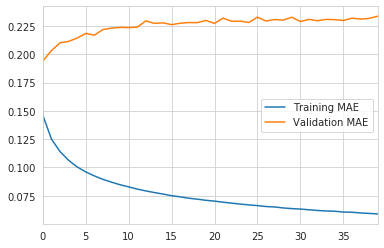

In [35]:
# Convert training history to a DataFrame.
df = pd.DataFrame(history_regr.history)

# Rename the relevant columns.
names = {'mae': 'Training MAE', 'val_mae': 'Validation MAE'}
df = df[['mae', 'val_mae']].rename(columns=names)

# Plot the results.
df.plot()

### Regression Results

Let us now compute some performance measures for the Neural Network. First we use the fitted model to predict the stock-returns for the training- and test-sets:

In [36]:
%%time
y_train_pred = model_regr.predict(X_train.values)
y_test_pred = model_regr.predict(X_test.values)

CPU times: user 29.6 s, sys: 2.01 s, total: 31.6 s
Wall time: 21.2 s


We can then calculate the $R^2$ value (aka. the coefficient of determination) between the actual stock-returns and those predicted by the model. A value of 1 means a perfect prediction, while a value of 0 means the model basically predicted the average stock-return, and a negative value means the model's prediction was worse than just using the average stock-return.

The $R^2$ value is about 0.5 for the training-set, which is OK but could be much higher if we trained it more, and if we used a bigger Neural Network with more parameters to optimize.

In [37]:
r2_score(y_true=y_train, y_pred=y_train_pred)

0.4976140337851359

But the $R^2$ value is very negative for the test-set, which is so bad, that it would be much better to just use the average stock-return. This shows the model has not learned the underlying relation between the signals X and stock-returns y. The model has merely learned noise or peculiarities in the training-data, which do not generalize to the unseen data in the test-set:

In [38]:
r2_score(y_true=y_test, y_pred=y_test_pred)

-0.7089485805293441

### Regression Examples

We can also try and plot the model's predicted versus actual stock-returns for a stock in the training-set. As we can see, the model has learned this mapping reasonably well:

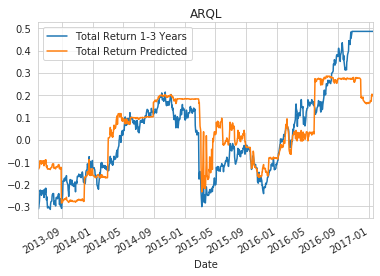

In [39]:
# Column-name for the models' predicted stock-returns.
TOTAL_RETURN_PRED = 'Total Return Predicted'

# Create a DataFrame with actual and predicted stock-returns.
# This is for the training-set.
df_y_train = pd.DataFrame(y_train)
df_y_train[TOTAL_RETURN_PRED] = y_train_pred

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_train[0]
_ = df_y_train.loc[ticker].plot(title=ticker)

Now let us try and plot the model's predicted versus actual stock-returns for the first stock in the test-set. As we can see, the model is mostly unable to predict the stock-returns, for this data that it has not seen during its training:

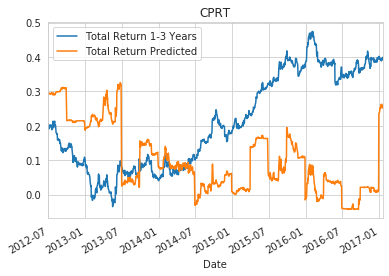

In [40]:
# Create a DataFrame with actual and predicted stock-returns.
# This is for the test-set.
df_y_test = pd.DataFrame(y_test)
df_y_test[TOTAL_RETURN_PRED] = y_test_pred

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_test[0]
_ = df_y_test.loc[ticker].plot(title=ticker)

## Neural Network: Classification

Instead of mapping from signals X to a continuous variable y for the stock-return, we can try and map to discrete output-classes that indicate if the stock-return was a gain or loss. This is a so-called binary classification problem, and perhaps that is easier for the Neural Network.

### Convert Output Data

First we need to convert the stock-returns into 1 for gains and 0 for losses, and then split into training- and test-sets:

In [41]:
%%time
# Convert stock-returns to binary classes where loss=0 and gain=1
# In the previous tutorial we just used the sign directly, but it
# is easier in TensorFlow / Keras to use class-values of 0 and 1.
df_cls = (np.sign(df_sig_rets[TOTAL_RETURN_1_3Y]) + 1) * 0.5

# Split the classes into training- and test-sets.
y_train_cls = df_cls.loc[tickers_train]
y_test_cls = df_cls.loc[tickers_test]

CPU times: user 2.98 s, sys: 9.1 ms, total: 2.99 s
Wall time: 2.99 s


Because this is a binary classification problem (the result is either a gain or a loss), we could build a Neural Network to use `y_train_cls` directly. But instead we want to build a more general type of Neural Network which supports any number of output classes. For this we must convert the output to so-called one-hot encoded arrays, so a class of 0 (loss) becomes the array `[1,0]` and a class of 1 (gain) becomes the array `[0,1]`.

In [42]:
# Convert classes to one-hot-encoded arrays.
y_train_one_hot = to_categorical(y=y_train_cls.values,
                                 num_classes=2)

# Show the result.
y_train_one_hot

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

The training-set is also biased because it contains many more samples with gains compared to losses:

In [43]:
# Fraction of the training-set that is classified as gains.
gain_fraction = (y_train_cls == 1.0).sum() / len(y_train_cls)
loss_fraction = 1.0 - gain_fraction

# Show it.
gain_fraction

0.7068901617250674

When we train the Neural Network further below, we need to provide new class-weights to counter this imbalance between the two classes:

In [44]:
# Calculate the class-weights.
class_weight = compute_class_weight('balanced',
                                    y=y_train_cls,
                                    classes=[0.0, 1.0])

# Show them.
class_weight

array([1.70584516, 0.70732347])

We can check that when we multiply these weights by the class-fractions for losses and gains, they both end up with the same weights:

In [45]:
class_weight * [loss_fraction, gain_fraction]

array([0.5, 0.5])

### Build and Train Neural Network: Classification

Now that we have prepared the classification data, we can proceed to build the Neural Network. We will use the same overall design as for the regression model above, with minor changes for the classification task.

In [46]:
# The activation function applied after each layer.
# It is important to use a non-linear function, otherwise
# the Neural Network cannot learn non-linear mappings.
activation = 'relu'

In [47]:
# Create a new Keras model.
model_clf = keras.Sequential()

# Add an input layer for the signals.
# Note how we set the dimensionality of the input here.
model_clf.add(InputLayer(input_shape=(num_signals,)))

# Add several dense aka. fully-connected layers.
# You can experiment with different designs.
model_clf.add(Dense(128, activation=activation))
model_clf.add(Dense(64, activation=activation))
model_clf.add(Dense(32, activation=activation))
model_clf.add(Dense(16, activation=activation))
model_clf.add(Dense(8, activation=activation))

# Add a layer for the output of the Neural Network.
# This has 2 outputs, one for each possible class, and it uses
# the softmax activation function for classification.
model_clf.add(Dense(2, activation='softmax'))

# Compile the model but don't train it yet.
# Note that it uses a different loss-function and metric
# than the regression-model above.
model_clf.compile(loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer=RMSprop(0.001))

# Show the model.
model_clf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               3200      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 18        
Total params: 14,218
Trainable params: 14,218
Non-trainable params: 0
__________________________________________________

We can now train the model. This takes a minute or two on an ordinary computer:

In [48]:
%%time
history_clf = model_clf.fit(x=X_train.values, y=y_train_one_hot,
                            class_weight=class_weight, **fit_args)

Train on 712320 samples, validate on 178080 samples
Epoch 1/40
712320/712320 [==============================] - 2s 3us/sample - loss: 0.5485 - accuracy: 0.7389 - val_loss: 0.6236 - val_accuracy: 0.6729
Epoch 2/40
712320/712320 [==============================] - 1s 2us/sample - loss: 0.4801 - accuracy: 0.7778 - val_loss: 0.6679 - val_accuracy: 0.6533
Epoch 3/40
712320/712320 [==============================] - 1s 2us/sample - loss: 0.4369 - accuracy: 0.8045 - val_loss: 0.7097 - val_accuracy: 0.6524
Epoch 4/40
712320/712320 [==============================] - 1s 2us/sample - loss: 0.4043 - accuracy: 0.8239 - val_loss: 0.7599 - val_accuracy: 0.6606
Epoch 5/40
712320/712320 [==============================] - 1s 2us/sample - loss: 0.3756 - accuracy: 0.8403 - val_loss: 0.8002 - val_accuracy: 0.6617
Epoch 6/40
712320/712320 [==============================] - 1s 2us/sample - loss: 0.3505 - accuracy: 0.8540 - val_loss: 0.8559 - val_accuracy: 0.6635
Epoch 7/40
712320/712320 [======================

We can then plot the training-progress as the classification accuracy which is supposed to be maximized. After 40 epochs through the training-set, the model has learned to map from signals to stock gain/loss for the training-set, with an accuracy of about 96% (this is not for the entire training-set, but only for one or more batches of data).

Unfortunately, the performance on the validation-set gets worse during optimization and ends with an accuracy of about 60%, so the model is clearly not learning the underlying relation between signals and stock gain/loss, but it has instead learned peculiarities and noise in the training-data.

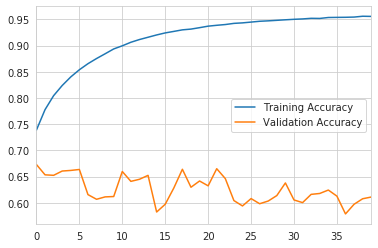

In [49]:
# Convert training history to a DataFrame.
df = pd.DataFrame(history_clf.history)

# Rename the relevant columns.
names = {'accuracy': 'Training Accuracy',
         'val_accuracy': 'Validation Accuracy'}
df = df[['accuracy', 'val_accuracy']].rename(columns=names)

# Plot the results.
df.plot()

### Classification Results

We can then use the fitted model to predict the classes for the training- and test-sets:

In [50]:
%%time
y_train_pred_cls = model_clf.predict(X_train.values)
y_test_pred_cls = model_clf.predict(X_test.values)

CPU times: user 32 s, sys: 2.25 s, total: 34.2 s
Wall time: 23 s


The Neural Network has 2 outputs which is a likelihood score for each of the two classes:

In [51]:
y_test_pred_cls

array([[0.00180785, 0.99819213],
       [0.00175658, 0.99824345],
       [0.00175229, 0.99824774],
       ...,
       [0.51388144, 0.48611856],
       [0.5675287 , 0.4324713 ],
       [0.55133164, 0.44866836]], dtype=float32)

Let us convert this to a single integer class-number, by taking the so-called argmax, which is the index of the largest element in each row:

In [52]:
# Convert one-hot-encoded arrays to integer class-numbers.
y_train_pred_cls = y_train_pred_cls.argmax(axis=1)
y_test_pred_cls = y_test_pred_cls.argmax(axis=1)

# Show the result.
y_test_pred_cls

array([1, 1, 1, ..., 0, 0, 0])

We can now calculate the classification accuracy for the entire training-set, which is almost 90%, so the model has learned to map financial signals to gain/loss classifications for 1-3 year investment periods:

In [53]:
accuracy_score(y_true=y_train_cls, y_pred=y_train_pred_cls)

0.8960455974842767

Unfortunately this performance does not generalize to the test-set, which the model has not seen during training. Here the classification accuracy is much lower:

In [54]:
accuracy_score(y_true=y_test_cls, y_pred=y_test_pred_cls)

0.6093554250622981

This is even worse than simply guessing that the stock-returns are always gains, which would give a classification accuracy of about 70%:

In [55]:
# Fraction of the test-set that is classified as gains.
(y_test_cls == 1.0).sum() / len(y_test_cls)

0.7024723359862238

### Confusion Matrix

We can also plot a so-called Confusion Matrix, which shows how well the classes were predicted. First we need a small helper-function for making the plot:

In [56]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plot a classification confusion matrix.
    
    :param y_true: Array of true classes.
    :param y_pred: Array of predicted classes.
    """
    
    # Class labels.
    labels = [1.0, 0.0]
    labels_text = ['Gain', 'Loss']

    # Create confusion matrix.
    mat = confusion_matrix(y_true=y_true, y_pred=y_pred,
                           labels=labels)
    
    # Normalize so all matrix entries sum to 1.0
    mat = mat / len(y_true)
    
    # Plot the matrix as a heatmap.
    sns.heatmap(mat, robust=True,
                xticklabels=labels_text,
                yticklabels=labels_text)

For the training-set, we again see that the model has learned to accurately classify gains and losses. Note how the colours are different, because the training-set contains many more gains than losses.

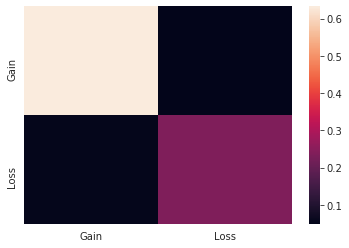

In [57]:
plot_confusion_matrix(y_true=y_train_cls, y_pred=y_train_pred_cls)

The confusion matrix for the test-set, shows that many classes were correctly predicted as gains, and there were a lot of errors in the rest of the predictions:

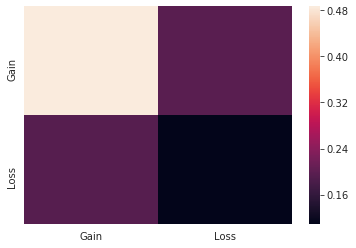

In [58]:
plot_confusion_matrix(y_true=y_test_cls, y_pred=y_test_pred_cls)

### Classification Examples

We can also try and plot the model's predicted versus actual gain/loss classification for a stock in the training-set. As we can see, the model has learned this mapping quite well:

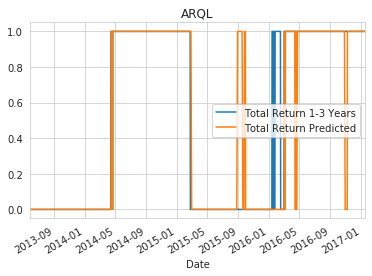

In [59]:
# Create a DataFrame with actual and predicted classifications.
# This is for the training-set.
df_y_train_cls = pd.DataFrame(y_train_cls)
df_y_train_cls[TOTAL_RETURN_PRED] = y_train_pred_cls

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_train[0]
_ = df_y_train_cls.loc[ticker].plot(title=ticker)

Now let us try and plot the model's predicted versus actual gain/loss classifications for the first stock in the test-set. As we can see, the model is quite bad at predicting this for data that it has not seen during its training:

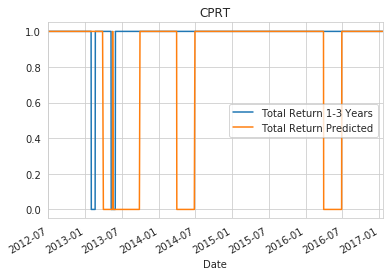

In [60]:
# Create a DataFrame with actual and predicted classifications.
# This is for the test-set.
df_y_test_cls = pd.DataFrame(y_test_cls)
df_y_test_cls[TOTAL_RETURN_PRED] = y_test_pred_cls

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_test[0]
_ = df_y_test_cls.loc[ticker].plot(title=ticker)

## Discussion

We used a Neural Network to learn the relation between signals and future stock-returns. This worked reasonably well on the training-data, but it did not generalize to the test-data, where the Neural Network performed worse than just guessing. In fact, the result was even worse than the previous tutorial which used a Machine Learning (ML) model called a Random Forest.

The problem might be the design of the Neural Network, that is, the number and size of the layers, their activation functions, etc. You can try and use so-called Hyper-Parameter Optimization such as the [Keras Tuner](https://keras-team.github.io/keras-tuner/), to try and find a better design for the Neural Network.

But we have now seen two very different ML models having the same problem with this dataset, so perhaps it means that these financial signals simply cannot be used to predict future stock-returns for 1-3 year investment periods.


### Machine Learning vs. Good Science

In the previous tutorial, we had a brief discussion about Machine Learning versus Good Science. We made an important point that is worth repeating here.

In general, these experiments show that Machine Learning cannot replace good science. Even if the ML model had performed well on the test-data, it would not have provided an explanation for the underlying relation between signals and stock-returns, so we would not know whether it was truly something that would work in the future. To explain this we need proper scientific reasoning.

A good example of scientific reasoning is the discovery and formulation of the Law of Gravity. A simple experiment would be to drop various items from different heights and take lots of measurements of how fast the items fall to the ground.

You can then make a noisy scatter-plot that shows the relation between item-size, item-weight, drop-height, and drop-speed. Statistical analysis would be able to give you a rough idea whether there is some relation in the data and if it is statistically significant, so the observed data is probably not just due to random chance. 

Machine Learning takes this one step further, in that it might be able to create a mathematical or computational model for the non-linear relation in the data, so you could use the ML model to predict the drop-speed if you input the other data. But the ML model would not be able to explain *why* this relation exists in the data. For this we need a proper theoretical framework such as Classical Mechanics in the case of the Law of Gravity.


### Predicting Long-Term Stock Returns

When it comes to predicting long-term stock-returns, there are actually only 3 factors that matter: The future dividends, sales-growth, and change in the P/Sales valuation ratio. (You could instead use earnings-growth or book-value growth, and the P/E or P/Book valuation ratios.) If we can predict the future dividend, sales-growth and P/Sales ratio, then we can predict the future stock-return.

When making scatter-plots of historical P/Sales ratios versus long-term stock-returns, we often see a particular downwards-sloping curve, and it turns out there is a certain formula for this curve, which is derived from the mathematical definition of Annualized Return, see [here](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb). The formula takes as input the average dividend yield, sales-growth and P/Sales ratios that you predict for the future, and produces a curve that can be used to predict future stock-returns from these 3 factors and the P/Sales ratio today. The accuracy of the prediction depends on how well you have predicted these 3 factors.

Machine Learning cannot uncover and explain such relations, whether it is the Law of Gravity, or the formula for long-term stock-returns. Human reasoning is still needed for this.

## License (MIT)

This is published under the
[MIT License](https://github.com/simfin/simfin-tutorials/blob/master/LICENSE.txt)
which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/simfin/simfin-tutorials).
